In [176]:
from shapely.geometry import Polygon, Point, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import math
import random

In [2]:
'''
Create crosswalk, start, end, goalLine:
    crosswalk - shapely.Polygon
    start, end - shapely.Point
    goalLine - shapely.LineString

'''

# Road specification:
# width: 6m - 20m
# Crosswalk specification:
# width: 1.8m - ?m

# Create crosswalk area as Polygons
crosswalk = Polygon([(4, 0), (3, 3), (0, 6), (9, 6), (6, 3), (5, 0)])

# Create start point and end point.
start = Point((4.5, 0))
end = Point((4.5, 6))
goalLine = LineString([(0, 6), (8, 6)])

In [3]:
'''Functions that might be useful'''

# Find m and b
def fx(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    
    # b = y - mx
    b = point1.y - (m * point1.x)
    print("b =", b)
    
    return m, b

# Find only m
def slope(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    return m

# Find only b
def y_intercept(point, m):
    # b = y - mx
    b = point.y - (m * point.x)
    print("b =", b)
    return b

# Find distance from point to line
# Equations to find point to line:
# +=d = (mx3 - y3 + C) / ((m^2 + 1)) ^ 0.5
def distance(point, m, b):
    x = point.x
    y = point.y
    d = (m * x - y + b) / ((m ** 2 + 1)) ** 0.5
    return d

# Find a random side given a polygon
def randSide(polygon):
    x,y = polygon.exterior.xy
    n = len(x) - 1
    index = random.randint(-1, n-1)
    pointA = Point((x[index], y[index]))
    pointB = Point((x[index+1], y[index+1]))
    return LineString([pointA, pointB])

In [4]:
# Generate n intermediate points given start and end point.
def pointsOnLine(start, end, n):
    pointsOL = [start]
    line = LineString([start, end])
    gap = 1 / (n + 1)
    d = gap
    for i in range(n):
        point = line.interpolate(d, normalized=True)
        d = d + gap
        pointsOL.append(point)
    pointsOL.append(end)
    return pointsOL

In [5]:
# Rotate a single point +-90 degrees given an origin.
def pointRotate(point, origin, degree=90):
    rotated_point = affinity.rotate(point, degree, origin=origin)
    return rotated_point

In [6]:
# Find a random point on a straight line between two points.
def pointBetween(start, end, d):
    line = LineString([start, end])
    point = line.interpolate(d, normalized=True)
    return point

In [7]:
def closestEnd(point, goalLine):
    d = goalLine.project(point)
    end = goalLine.interpolate(d)
    return end

In [8]:
# Find the angle in radian between two given lines
# Formula:
# atan2(vec2.y-vec1.y, vec2.x-vec1.x)

def degreeBetween(line1, line2):
    # Extract points from line1 and line2
    l1_x, l1_y = [line1.bounds[0], line1.bounds[1]], [line1.bounds[2], line1.bounds[3]]
    l2_x, l2_y = [line2.bounds[0], line2.bounds[1]], [line2.bounds[2], line2.bounds[3]]
    # Create vector1 and vector2
    v1 = [l1_x[1] - l1_x[0], l1_y[1] - l1_y[0]]
    v2 = [l2_x[1] - l2_x[0], l2_y[1] - l2_y[0]]

    # Find theta using formula
    theta = math.atan2(v2[1] - v1[1], v2[0] - v1[0])
    
    return theta

In [280]:
# Add angle restraints:
# Absolute_max - max angle between new line and verticle line goes through start point and closest end point.
# Delta_max - max angle between new line and previous line

def shiftedPoints(start, end, crosswalk, goalLine, maxAbsDegree, maxDeltaDegree, nInterPoints=3, maxInterPointsDistance=1.5):
    new_points = [start]
    pointsOL = pointsOnLine(start, end, nInterPoints)
    for i in range(len(pointsOL) - 2):
        print("---------------------------------------------", i)
        count = 0
        start = pointsOL[1]
        end = pointsOL[2]
        done = False
        while not done:
            count += 1
            if count >= 1000:
                print("breaking...")
                break
            chance = random.choice([0, 1])
            pointToRot = pointBetween(start, end, d=random.uniform(0, 1)) # modify d if needed
            if chance == 0:
                new_point = pointRotate(pointToRot, start, degree=90)
                
            else:
                new_point = pointRotate(pointToRot, start, degree=-90)
            # Check constraints
            if crosswalk.contains(new_point):
                segment = LineString([start, end])
                new_line = LineString([new_point, new_points[-1]])
                prev_line = None
                if i > 0:
                    prev_line = LineString([new_points[-2], new_points[-1]])
                if new_line.length <= segment.length*maxInterPointsDistance:
                    if prev_line == None:
                        done = True
                    else:
                        # Find verticle line
                        vert_start = new_point
                        vert_end = closestEnd(new_point, goalLine)
                        vert_line = LineString([vert_start, vert_end])
                        # Calculate the angle between the new line and the verticle line
                        a_theta = degreeBetween(new_line, vert_line)
                        # Calculate the angle between the new line and the extended previous line
                        d_theta = math.pi - abs(degreeBetween(new_line, prev_line))
                        print("check...")
                        print("a_theta:", a_theta, "max:", maxAbsDegree)
                        print("d_theta:", d_theta, "max:", maxDeltaDegree)
                        if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and d_theta <= maxDeltaDegree:
                            done = True
        
        new_points.append(new_point)
        new_start = new_point
        extend_end = new_line.interpolate(10, normalized=True)
        new_end = closestEnd(extend_end, goalLine)
        
        pointsOL = pointsOnLine(new_start, new_end, nInterPoints-(i+1))

    # final rotate to find end point is different
    final_start = new_end
    final_end = new_start
    done = False
    while not done:
        pointToRot = pointBetween(final_start, final_end, d=random.uniform(0, 1))
        chance = random.random()
        if chance > 0.5:
            final_rot = pointRotate(pointToRot, final_start, degree=90)
            segment = LineString([final_start, final_end])
            line = LineString([new_point, new_points[-1]])
            if line.length <= segment.length*maxInterPointsDistance:
                
                done = True
        else:
            final_rot = pointRotate(pointToRot, final_start, degree=-90)
            segment = LineString([final_start, final_end])
            line = LineString([new_point, new_points[-1]])
            if line.length <= segment.length*maxInterPointsDistance:
                done = True
    if goalLine.contains(final_rot) == False:
        final_rot = closestEnd(final_rot, goalLine)
    new_points.append(final_rot)
                    
    return new_points

iteration: 0
--------------------------------------------- 0
--------------------------------------------- 1
check...
a_theta: 1.2539235252735217 max: 1.0471975511965976
d_theta: 0.6318529735209193 max: 0.7853981633974483
check...
a_theta: 1.1614435425096359 max: 1.0471975511965976
d_theta: 0.998587165948992 max: 0.7853981633974483
check...
a_theta: 1.2517417857719388 max: 1.0471975511965976
d_theta: 0.6377192601207873 max: 0.7853981633974483
check...
a_theta: 1.1705577077321425 max: 1.0471975511965976
d_theta: 0.8641934693905111 max: 0.7853981633974483
check...
a_theta: 1.1329846819495741 max: 1.0471975511965976
d_theta: 1.0355497487207361 max: 0.7853981633974483
check...
a_theta: 1.2591284332248907 max: 1.0471975511965976
d_theta: 0.617922382011761 max: 0.7853981633974483
check...
a_theta: 1.2109744842988177 max: 1.0471975511965976
d_theta: 0.9265583271653401 max: 0.7853981633974483
check...
a_theta: 1.3098572697636586 max: 1.0471975511965976
d_theta: 0.7467262361518232 max: 0.785398

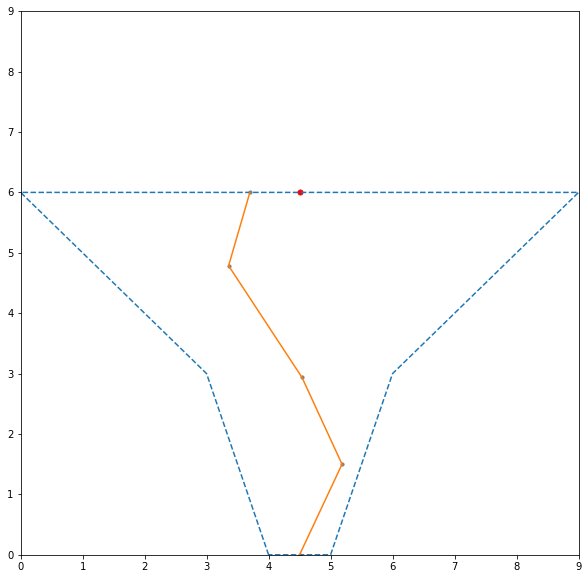

In [281]:
# Plot polygons and points

plt.rcParams["figure.figsize"] = (10,10)
x,y = crosswalk.exterior.xy
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=25, color='red')

maxAbsDegree = math.pi/3
maxDeltaDegree = math.pi/4


for i in range(1):
    line_x = []
    line_y = []
    print("iteration:", i)
    new_points = shiftedPoints(start, end, crosswalk, goalLine, maxAbsDegree, maxDeltaDegree)
    #print("visualization:")

    for i in range(len(new_points)):
        line_x.append(new_points[i].x)
        line_y.append(new_points[i].y)
        #print(new_points[i])
        plt.scatter(new_points[i].x, new_points[i].y, s=10, color='grey')
        

    plt.plot(line_x, line_y)
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.savefig('trial.png')